In [55]:
import pandas as pd
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv2
%matplotlib inline


from tensorflow.python.keras import callbacks, optimizers
from tensorflow.python.keras.models import Model, load_model, model_from_json
from tensorflow.python.keras.preprocessing import image
from tensorflow.python.keras.layers import Input, Dense, Flatten, Conv2D, MaxPooling2D, Activation, BatchNormalization, Conv2DTranspose, Concatenate, LSTM, Reshape, Embedding
from tensorflow.python.keras.layers.merge import add
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf
from tensorflow.keras import backend as K
 

 
K.set_image_data_format('channels_last')

Был использован набор машин с видимыми номерами и размечены маски вручную, затем аугментирован. Количество примеро 2367, что не так немного, но для демонстрации работы достаточен

Будем использовать сеть Unet для поиска на изображении фрагмента содержащего номер.
Пропишем пути к каталогам с изображениями и масками

In [379]:
directories = '/home/godovalovpv/PycharmProjects/test_project/train/'
mask_dir = directories+'mask/'
train_dir = directories+'number/'
image_shape = (256,256)


Посмотрим на изображение одной из маск

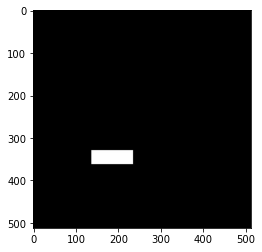

In [380]:
im = cv2.imread(mask_dir+'1.jpg')
plt.imshow(im)

Функция подготовки маски. обозначим пиксели 0 - фон, 1 - маска

In [381]:

def preprocess_mask_image2(image, class_num, color_limit):
  pic = np.array(image)
  img = np.zeros((pic.shape[0], pic.shape[1], 1))  
  np.place(img[ :, :, 0], pic[ :, :, 0] >= color_limit, 1)  
  return img



Функция потерь. Будем использовать Dice функцию

In [382]:
def dice_coef(y_true, y_pred):

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0) 
 
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)




Генератор для обучения сети, возвращающий минибатч изображения и маски. Входное изображение нормализует пиксели в диапазон от 0 до 1

In [383]:

def train_generator(img_dir, label_dir, batch_size, input_size):
    list_images = os.listdir(label_dir)
    # shuffle(list_images) #Randomize the choice of batches
    ids_train_split = range(len(list_images))

    while True:
         for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y_batch = []

            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]

            for id in ids_train_batch:
              img_name = img_dir + list_images[id]
              mask_name = label_dir + list_images[id]
  
              img = cv2.imread(img_name) 
              img  = cv2.resize(img, image_shape, interpolation=cv2.INTER_AREA)
  
              mask = cv2.imread(mask_name)
              mask = cv2.resize(mask, image_shape, interpolation=cv2.INTER_AREA)
              mask = preprocess_mask_image2(mask, 2, 50)                
              
              x_batch += [img]
              y_batch += [mask]    

    
            x_batch = np.array(x_batch) / 255.
            y_batch = np.array(y_batch) 

            yield x_batch, np.expand_dims(y_batch, -1)



Нейросеть Unet


In [7]:
def unet(num_classes = 1, input_shape= (image_shape[0],image_shape[1], 3)):
  inp = Input(input_shape)
  # Block 1
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(inp)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
  x = BatchNormalization()(x)
  block_1_out = Activation('relu')(x)
  x = MaxPooling2D()(block_1_out)
  # Block 2
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
  x = BatchNormalization()(x)
  block_2_out = Activation('relu')(x)
  x = MaxPooling2D()(block_2_out)
  # Block 3
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
  x = BatchNormalization()(x)
  block_3_out = Activation('relu')(x)
  x = MaxPooling2D()(block_3_out)
  # Block 4
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)
  x = BatchNormalization()(x)
  block_4_out = Activation('relu')(x)
  
 
  
  x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP2')(block_4_out)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Concatenate()([x, block_3_out])
  x = Conv2D(256, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # UP 3
  x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP3')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Concatenate()([x, block_2_out])
  x = Conv2D(128, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  # UP 4
  x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same', name = 'Conv2DTranspose_UP4')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Concatenate()([x, block_1_out])
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(num_classes, (3, 3), activation='sigmoid', padding='same')(x)
 
  model = Model(inputs=inp, outputs=x)
  adam = tf.keras.optimizers.Adam(lr=0.001)
  
  model.compile(optimizer=adam,
                  loss=dice_coef_loss,
                  metrics=[dice_coef])
    # model.summary()
  return model

In [8]:
model = unet()

Начинаем обучение. Обучать будем на 4 эпохах, с сохранием каждой отдельной эпохи. Это было удобней, чтобы посмотреть результат распознавания после каждой эпохи.

In [28]:
batch_size = 8
history = model.fit_generator(train_generator(train_dir, mask_dir, batch_size, image_shape),                              
                              steps_per_epoch=297,
                              epochs=1,
                              verbose=1,
                              # callbacks=callbacks,
#                               validation_data=train_generator(val_dir, v_mask_dir, batch_size, image_shape),
#                               validation_steps=1,
                              class_weight=None,
                              max_queue_size=10,
                              workers=1
                              )

297/297 [==============================] - 20838s 70s/step - loss: 0.0803 - dice_coef: 0.9197


Сохраняем обученую модель и веса

In [31]:
model.save(directories+'unet_3.h5')
model_json = model.to_json()
json_file = open(directories+"unet_3_cnn.json", "w")
json_file.write(model_json)
json_file.close()
model.save_weights(directories+"unet_3_cnn.h5")

In [9]:

model.load_weights(directories+"unet_3_cnn.h5")

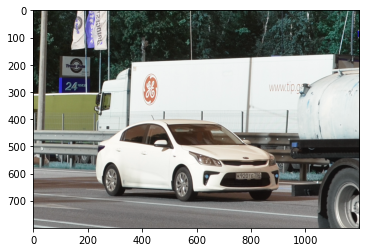

In [384]:
img_orig = cv2.imread('/home/godovalovpv/PycharmProjects/test_project/train/test/rio.jpg') 
img  = cv2.resize(img_orig, image_shape, interpolation=cv2.INTER_AREA)
plt.imshow(img_orig)

Напишем функцию для распознавания и отрисовки результата работы сети. Заодно вырежем из исходного изображения найденный фрагмент с номером и также посмотрим

In [385]:
def recogn_number(path):
    
    img_orig = cv2.imread(path)
    img  = cv2.resize(img_orig, image_shape, interpolation=cv2.INTER_AREA)
    img = np.expand_dims(img, 0)
    img_p = model.predict(img/255)
    img  = cv2.resize(img_p[0,:,:,0], (img_orig.shape[1],img_orig.shape[0]), interpolation=cv2.INTER_AREA)
    
    
    num_shape = np.where(img>0.5)
    y1 = num_shape[1].min()
    y2 = num_shape[1].max()
    x1 = num_shape[0].min()
    x2 = num_shape[0].max()
    
    num_copy = img_orig[x1:x2,y1:y2,:]
    plt.figure(figsize=(15,15))
    
    plt.subplot(1,3,1)
    plt.imshow(img_orig)    
    plt.subplot(1,3,2)
    plt.imshow(img)
    plt.subplot(1,3,3)
    plt.imshow(num_copy)
    plt.savefig(directories+str(x1)+'.png')
    return np.array(num_copy)
    
    
    
    

прогоним несколько тестовых файлов для распознавания

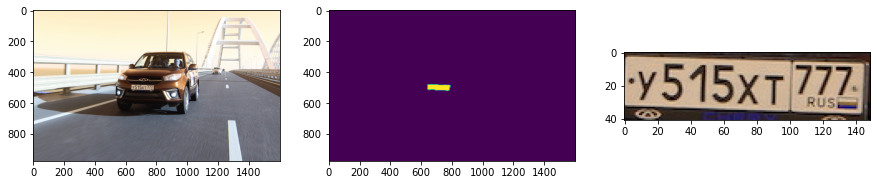

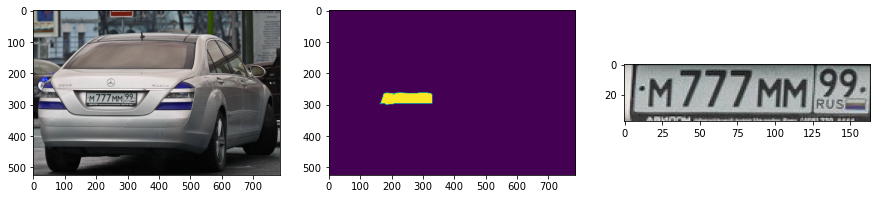

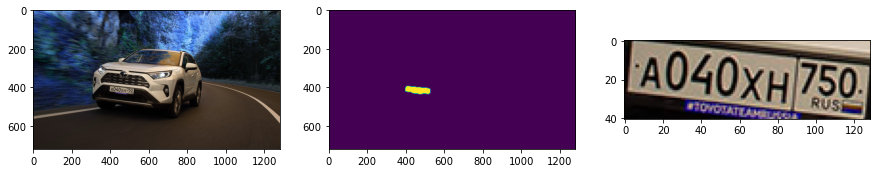

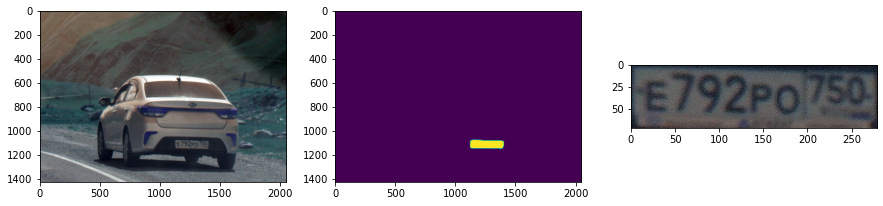

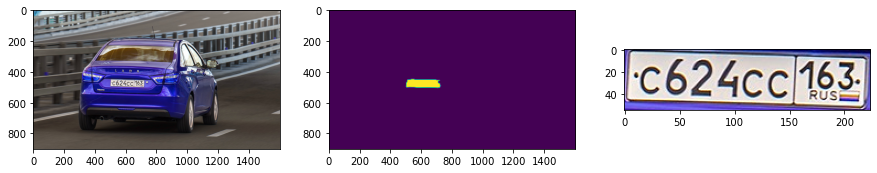

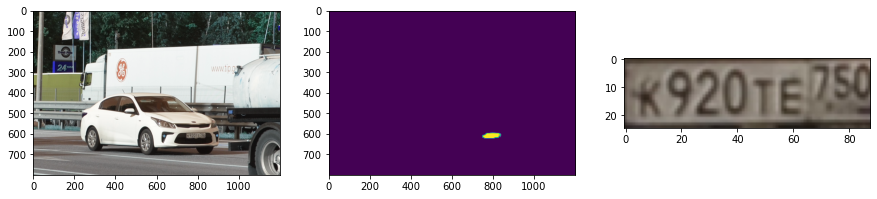

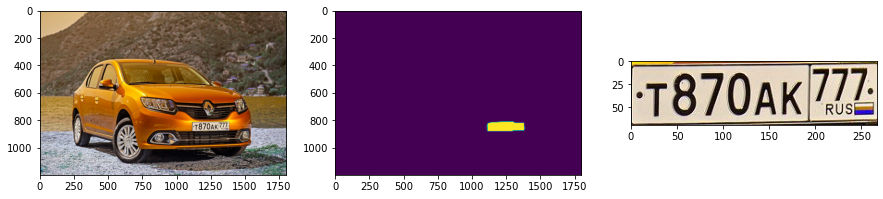

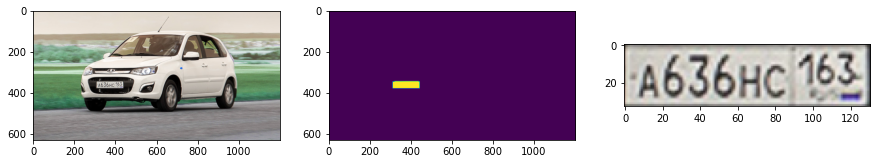

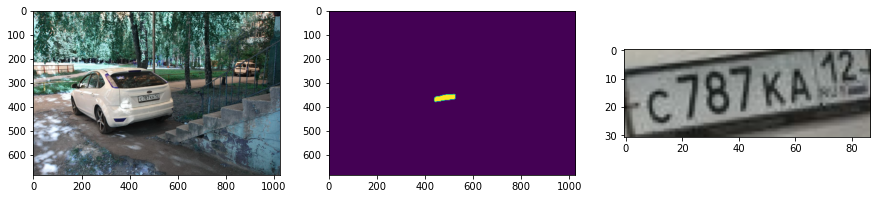

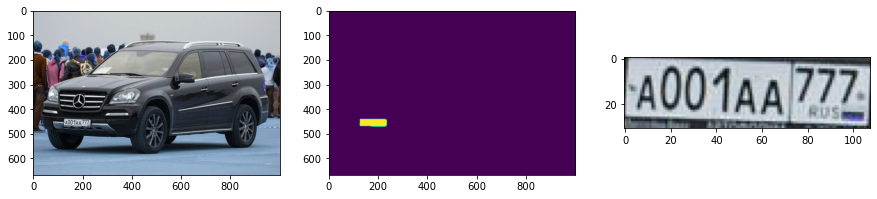

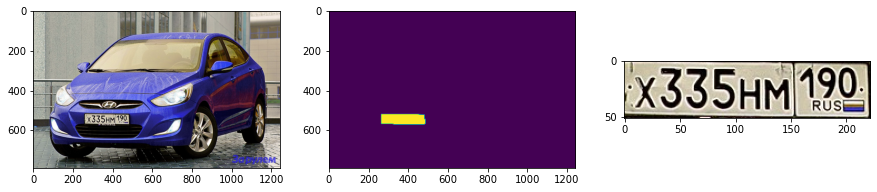

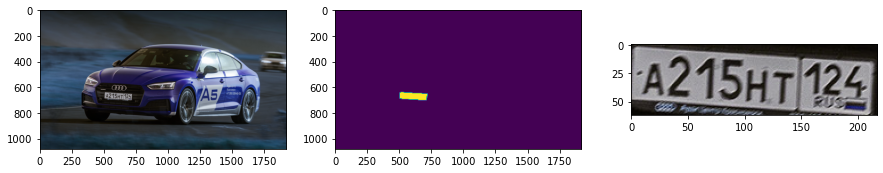

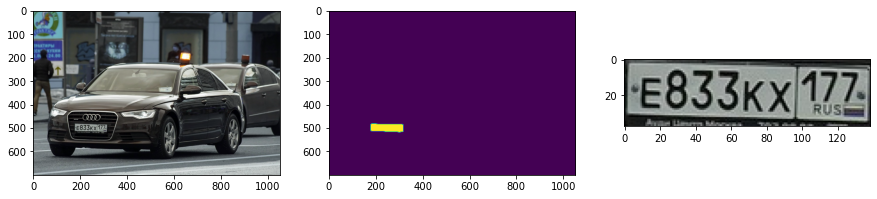

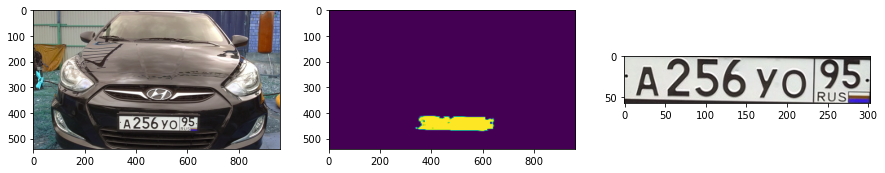

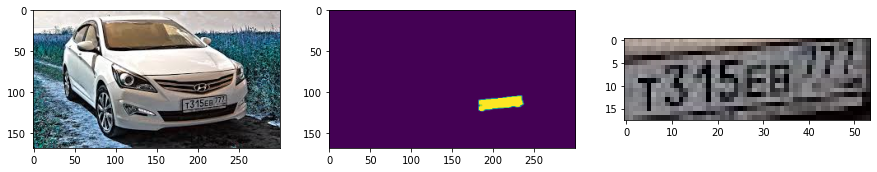

In [386]:
test_dir=directories+'test/'
files = os.listdir(test_dir) 
num_array = []
for f in files:
    num_array +=[recogn_number(test_dir+f)]
    

Посмотрим на один из номеров поближе

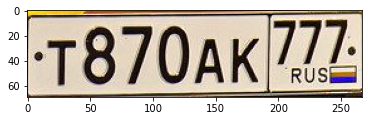

In [119]:
img13 = num_array[8]
plt.imshow(img13)

# Распознавание номера
## Раздел дорабатывается

In [17]:
import json

Посмотрим на структуру json файла. Был найден готовый датасет с размеченными номерами 

In [18]:
with open("/home/godovalovpv/PycharmProjects/test_project/train/auto_num/train/ann/1_11_2014_12_13_25_262_0.json", "r") as read_file:
    data = json.load(read_file)

data

{'tags': [],
 'objects': [],
 'state_id': '2',
 'region_id': '6',
 'size': {'width': 77, 'height': 16},
 'moderation': {'isModerated': 1,
  'moderatedBy': 'ApelSYN',
  'predicted': 'T222OX35'},
 'description': 'T222OX35',
 'name': '1_11_2014_12_13_25_262_0',
 'count_lines': '0'}

In [19]:
data['description']

'T222OX35'

Пути к каталогам для обучения сети изображение и файл с ответом

In [20]:
ann_dir='/home/godovalovpv/PycharmProjects/test_project/train/auto_num/train/ann/'
img_dir='/home/godovalovpv/PycharmProjects/test_project/train/auto_num/train/img/'


Подготовим список с символами использующиеся для госномеров

In [330]:
symbols_num = [str(i) for i in range(10)]
symbols_word= ['A', 'B', 'E', 'K', 'M', 'H', 'O', 'P', 'C', 'T', 'Y', 'X','?'] 
symbols = symbols_num+symbols_word
# symbols.index('6')

Напишем вспомогательные функции. tensor_to_num(num_tensor) - будет возврашать номер в текстовом виде из ответа сети.quest_sym(string) - будет дополянть строковое значение символом '?' так как код региона может состоять из 2 или 3 символов. К тому же длину вектора ответа мы сделаем кратной 2 длинной 16, для совпадения размерности слоев после пулинга.

In [348]:
def num_to_tensor(num_str):
    num_tensor =[]
    if len(num_str)<9: num_str+='?'
    for n in num_str:
        num_tensor+=[symbols.index(n)]    
    return num_tensor

def tensor_to_num(num_tensor):
    num_str = ''
    for n in num_tensor:
        
        num_str+=symbols[n-1]
        
    return num_str

# Если в коде региона не хватает символа
def quest_sym(string):
#     if len(string)<9:
    string+='?'*(16-len(string))
    return string


np.array(num_to_tensor(data['description']))
# tokenizer.texts_to_matrix(quest_sym(data['description']), mode = 'binary')

array([19,  2,  2,  2, 16, 21,  3,  5, 22])

In [205]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=24,filters='!"#$%&()*+,-./:;<=>@[\\]^_`{|}~\t\n')

In [206]:
tokenizer.fit_on_texts(symbols)
tokenizer.texts_to_sequences(quest_sym(data['description']))

[[20],
 [3],
 [3],
 [3],
 [17],
 [22],
 [4],
 [6],
 [23],
 [23],
 [23],
 [23],
 [23],
 [23],
 [23],
 [23]]

In [265]:

def num_generator(ann_dir, batch_size=5):
    
    list_images = os.listdir(ann_dir)    
    ids_train_split = range(len(list_images))

    while True:
         for start in range(0, len(ids_train_split), batch_size):
            x_batch = []
            y_batch = []

            end = min(start + batch_size, len(ids_train_split))
            ids_train_batch = ids_train_split[start:end]
            
            for id in ids_train_batch:
                ann_name = ann_dir + list_images[id] 
                
                with open(ann_name) as file:               
                    data = json.load(file)
            
                    img = cv2.imread(img_dir+data['name']+'.png')
                    img = cv2.resize(img, (288,64), interpolation=cv2.INTER_AREA) 
                    
                    x_batch += [img]
                    y_batch += [tokenizer.texts_to_matrix(quest_sym(data['description']), mode = 'binary')]
                    
#                     np.ndarray(num_to_tensor(data['description']))
                    
    
            x_batch = np.array(x_batch) / 255.
            
            yield x_batch, np.array(y_batch)


In [266]:
gen1 = num_generator(ann_dir, batch_size=5)


In [267]:
xxx,yyy = next(gen1)

In [268]:
yyy.shape



(5, 16, 24)

In [272]:
def CNN_RNN(num_classes = 1, input_shape= (288, 64, 3)):
  inp = Input(input_shape)
  # Block 1
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(inp)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)
  x = BatchNormalization()(x)
  block_1_out = Activation('relu')(x)
  x = MaxPooling2D()(block_1_out)
  # Block 2
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)
  x = BatchNormalization()(x)
  block_2_out = Activation('relu')(x)
  x = MaxPooling2D()(block_2_out)
  # Block 3
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)
  x = BatchNormalization()(x)
  block_3_out = Activation('relu')(x)
  x = MaxPooling2D()(block_3_out)
#   print(x)
#   x = Flatten()(x)
  reshape = Reshape((16, 4608))(x)
  x = Dense(32, activation = 'relu')(reshape) 
  lstm_1a = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name='LSTM_1a')(x)
  lstm_1b = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name='LSTM_1b', go_backwards=True)(x)
  lstm_1 = add([lstm_1a,lstm_1b])
  
  lstm_2a = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name='LSTM_2a')(lstm_1)
  lstm_2b = LSTM(256, return_sequences=True, kernel_initializer='he_normal', name='LSTM_2b', go_backwards=True)(lstm_1 )
  
  
#   lstm = LSTM(256, return_sequences=True,  name='LSTM_1')(reshape)
#   lstm = LSTM(64, name='LSTM_2')(lstm)
  conc = Concatenate()([lstm_2a, lstm_2b])
  x = Dense(24, kernel_initializer='he_normal', activation = 'softmax')(conc) 
  print(x)


 
  model = Model(inputs=inp, outputs=x)
  adam = tf.keras.optimizers.Adam(lr=0.001)
  
  model.compile(optimizer=adam,
                  loss=tf.keras.losses.CategoricalCrossentropy(),
                  metrics=['accuracy'])
    # model.summary()
  return model

Tensor("dense_69/truediv:0", shape=(None, 16, 24), dtype=float32)


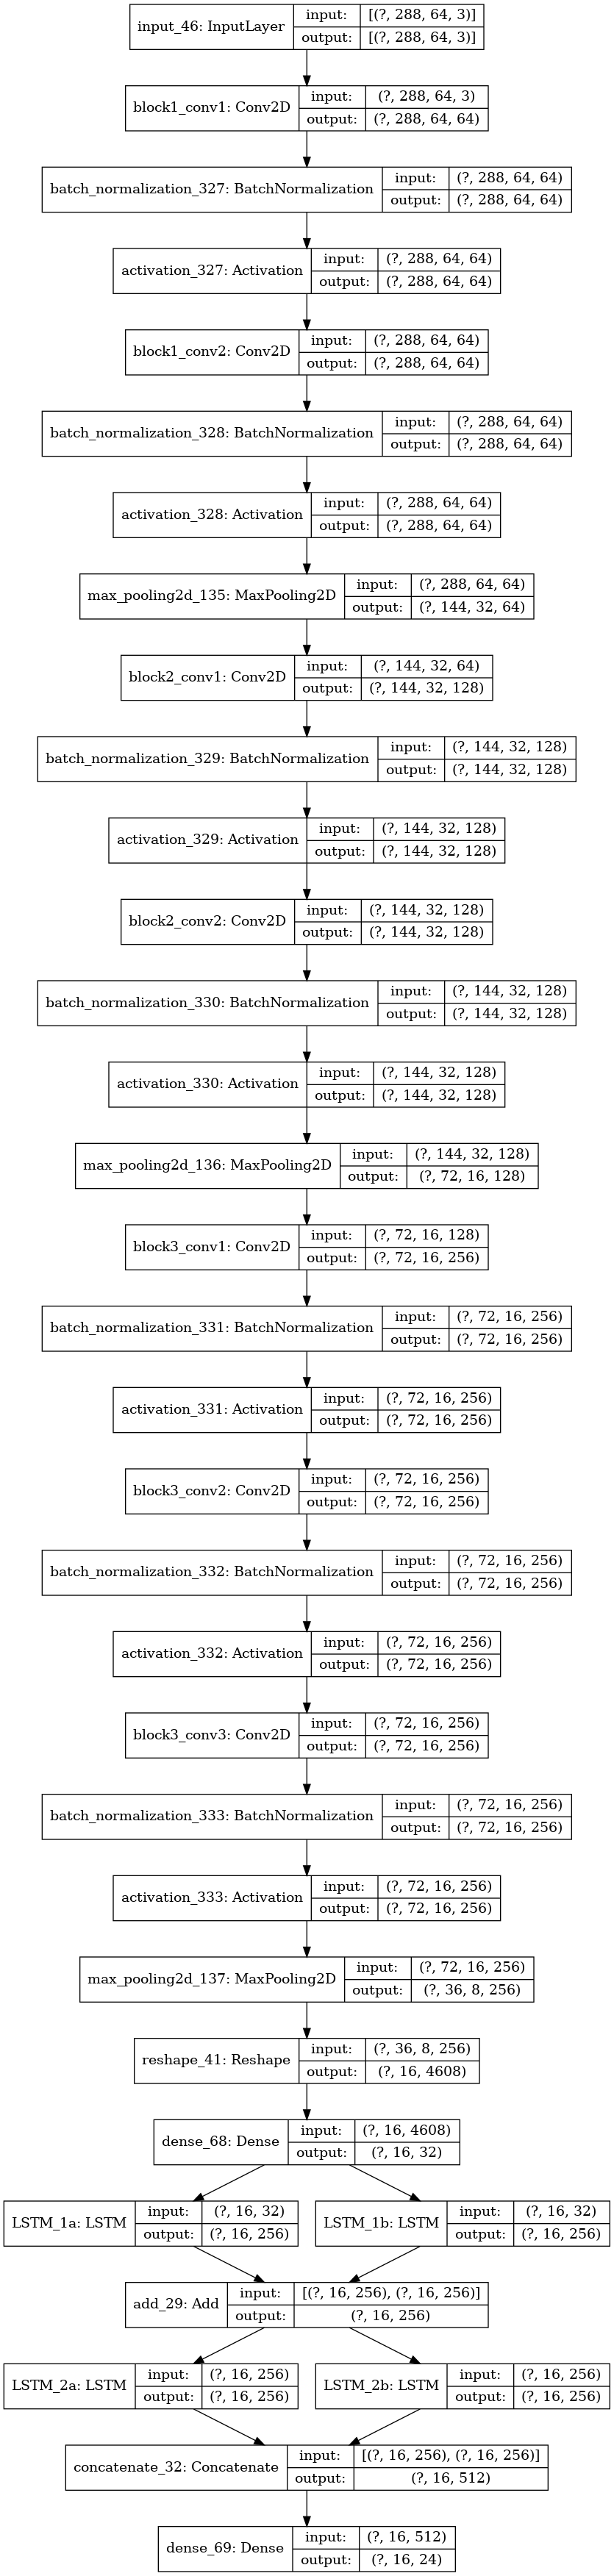

In [393]:
model2 = CNN_RNN()
# model2.summary()
tf.keras.utils.plot_model(model2, show_shapes = True, expand_nested = True)

In [394]:
batch_size = 40
history = model2.fit_generator(num_generator(ann_dir, batch_size),                              
                              steps_per_epoch=1236,
                              epochs=2,
                              verbose=1,
                              # callbacks=callbacks,
#                               validation_data=train_generator(val_dir, v_mask_dir, batch_size, image_shape),
#                               validation_steps=1,
                              class_weight=None,
                              max_queue_size=10,
                              workers=1
                              )

Epoch 1/2
1236/1236 [==============================] - 39273s 32s/step - loss: 0.4874 - accuracy: 0.8415
Epoch 2/2
1236/1236 [==============================] - 39211s 32s/step - loss: 0.0420 - accuracy: 0.9896


In [392]:
model2.save(directories+'numrecog/unet_numrecog_1.h5')
model2_json = model2.to_json()
json_file2 = open(directories+"numrecog/unet_numrecog_1.json", "w")
json_file2.write(model2_json)
json_file2.close()
model2.save_weights(directories+"numrecog/unet_numrecog_weight1.h5")

In [350]:
imim=cv2.resize(num_array[9], (288,64), interpolation=cv2.INTER_AREA)
imim = np.expand_dims(imim, 0)
nnn = model2.predict(imim/255)

In [395]:
def recogn_number_text(num_array):
   plt.figure(figsize=(15,15))  
   for i in range(len(num_array)):
        im = cv2.resize(num_array[i], (288,64), interpolation=cv2.INTER_AREA)
        im = np.expand_dims(im, 0)
        nnn = model2.predict(im/255)
        num = tensor_to_num(np.argmax(nnn[0], axis = 1))
           
        plt.subplot(5,3,i+1)
        plt.title(num.replace('?', ''))
        plt.imshow(num_array[i])   
        
        
#    return num

На лицо переобучение, необходимо упростить модель для лучших результатов

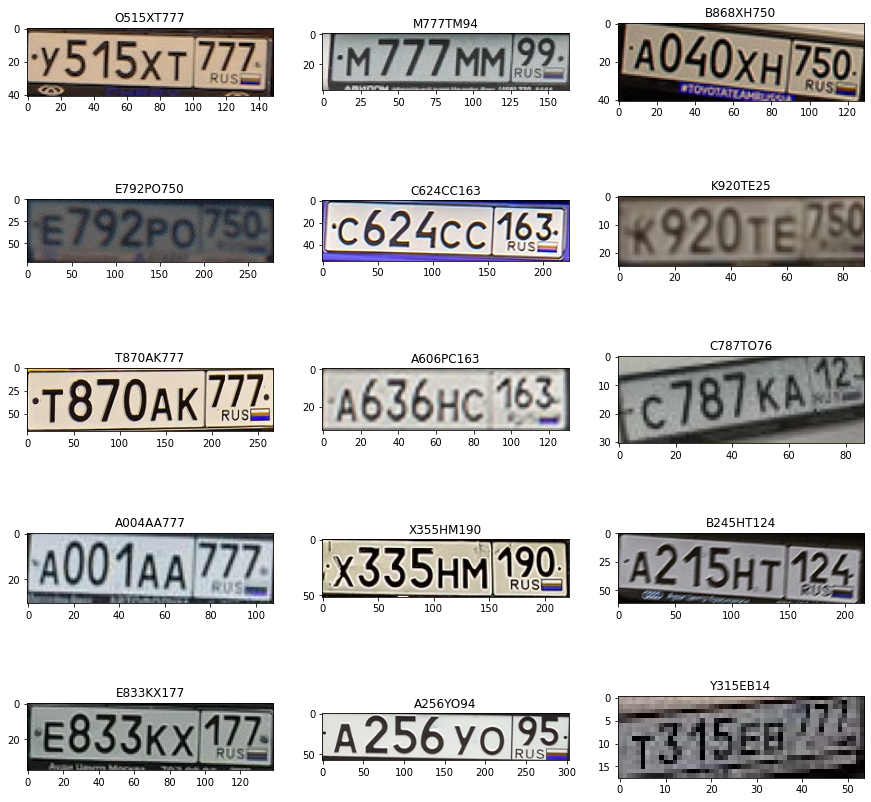

In [396]:
recogn_number_text(num_array)

In [351]:
np.argmax(nnn[0], axis = 1)

array([11,  7,  4,  7, 16, 19,  2,  7,  4, 23, 23, 23, 23, 23, 23, 23])

In [352]:
tensor_to_num(np.argmax(nnn[0], axis = 1))

'A636HC163???????'

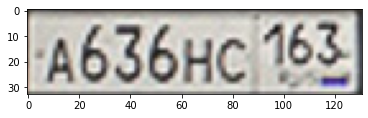

In [354]:
plt.imshow(num_array[9])

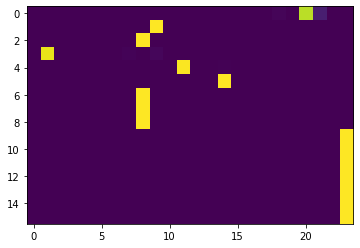

In [314]:
plt.imshow(nnn[0])

In [374]:
num_array[9].shape

(33, 131, 3)

In [315]:
quest_sym(data['description'])

'T222OX35????????'

In [316]:
one_hot_result = tokenizer.texts_to_matrix(quest_sym(data['description']), mode = 'binary')

In [317]:
one_hot_result

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 

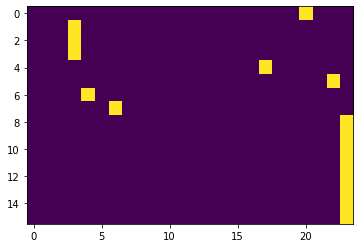

In [318]:
plt.imshow(one_hot_result)